In [1]:
%matplotlib inline
import numpy as np
import pandas as pnd
import seaborn as sns
import matplotlib.pyplot as plt

base_root = "../data/original/"

In [2]:
df_train_transaction = pnd.read_csv(base_root + "train_transaction.csv")
df_train_identity = pnd.read_csv(base_root + "train_identity.csv")
# Fusion des deux fichiers sur la base de la colonne TransactionID
full_train = pnd.merge(df_train_transaction, df_train_identity, on='TransactionID', how='left')
full_train.set_index("TransactionID", inplace=True)

# Gestion des données manquantes (NaN)
Dans cette version, les colonnes manquantes fortement corrélées sont supprimées.

In [3]:
nan_cols = full_train.columns[full_train.isna().sum() > 0]
# Correlation threshold
corr_thres = 0.8

# Select upper triangle of correlation matrix
corr_matrix = full_train[nan_cols].corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.80
to_drop = [column for column in upper.columns if any(upper[column] > corr_thres)]

# Drop features
full_train.drop(to_drop, axis=1, inplace=True)

Les valeurs manquantes des attributs numériques et catégoriques restants sont remplacées respectivement par leur médiane et leur mode.

In [4]:
from sklearn.impute import SimpleImputer

cat_cols = full_train.select_dtypes(exclude=np.number).columns
num_cols = list(full_train.select_dtypes(include=np.number).columns)
num_cols.remove("isFraud")

# Remplacement des valeurs numériques par la médiane
imputer = SimpleImputer(strategy="median")
full_train[num_cols] = imputer.fit_transform(full_train[num_cols].to_numpy())

# Retrait des colonnes catégoriques
full_train = full_train.drop(cat_cols, axis=1)

assert "isFraud" in full_train.columns, "target column removed by accident"
assert full_train.isna().sum().sum() == 0, "There are still missing values"
print("OK")

OK


## Débalancement des classes

Text(0, 0.5, 'count')

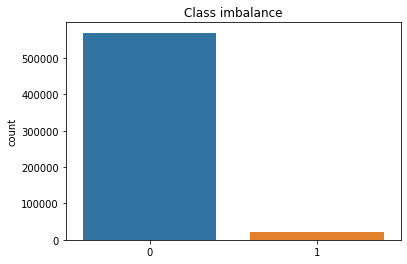

In [5]:
sns.barplot(y=full_train.isFraud.value_counts(), x=[0, 1])
plt.title("Class imbalance")
plt.ylabel("count")

In [ ]:
from imblearn.combine import SMOTEENN

X, y = full_train.drop("isFraud", axis=1), full_train["isFraud"]
smote_enn = SMOTEENN(random_state=0)
X_resampled, y_resampled = smote_enn.fit_resample(X, y)

df_balanced = pnd.concat((X_resampled, y_resampled), axis=1)
sns.barplot(y=df_balanced.isFraud.value_counts(), x=[0, 1])
plt.title("Class imbalance")
plt.ylabel("count")

## Normalisation

In [ ]:
# Scaling
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_balanced = scaler.fit_transform(df_balanced)

In [ ]:
# Sauvegarde des données
np.savez(base_root + "../fraud-detection-v3.npz", df_balanced)